In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({'legend.labelcolor': 'black'})

import numpy as np
from openpyxl import load_workbook

from scipy.fft import fft
from scipy.signal import welch

### Importação do excel e definição de variáveis

In [2]:
wb = load_workbook("grupo08.xlsx")
ws = wb.active

In [3]:
# Parametros da onda
N = 36000
t0 = 0; tf = 3600
t = np.linspace(t0, tf, N)

In [4]:
Z_ondaT = []; Z_heaveT = []                 # Ondas transientes
Z_onda1 = []; Z_onda2 = []; Z_onda3 = []    # Ondas irregulares
Z_heave1 = []; Z_heave2 = []; Z_heave3 = []

ws = wb['Transiente']
for row in range(2,N+2):
    Z_ondaT.append(ws['C' + str(row)].value)
    Z_heaveT.append(ws['D' + str(row)].value)

ws = wb['Irregular']
for row in range(2,N+2):
    Z_onda1.append(ws['C' + str(row)].value)
    Z_onda2.append(ws['D' + str(row)].value)
    Z_onda3.append(ws['E' + str(row)].value)
    Z_heave1.append(ws['F' + str(row)].value)
    Z_heave2.append(ws['G' + str(row)].value)
    Z_heave3.append(ws['H' + str(row)].value)

### Análise estatística no domínio do tempo

In [5]:
# Alterar variavel "data" para mudar onda analisada
data = Z_heaveT

In [6]:
nz = nc = 0
for e in range(N-1):
    if e == 0:
        aux = data[e]
    else:
        if aux*data[e] < 0:
            nz += 1
        if data[e] > data[e-1] and data[e] > data[e+1]:
            nc += 1
        aux = data[e]

print('Media =', np.mean(data))
print('Max =', np.max(data))
print('Min =', np.min(data))
print('Desv. Pad. =', np.std(data))
T = 3600/(nz/2)
print('Periodo entre zeros =', T)
print('Periodo entre cristas =', 3600/nc)

Media = 1.5685211658382152e-05
Max = 2.33218241784347
Min = -2.333710777091598
Desv. Pad. = 0.27779094380187364
Periodo entre zeros = 10.344827586206897
Periodo entre cristas = 7.725321888412017


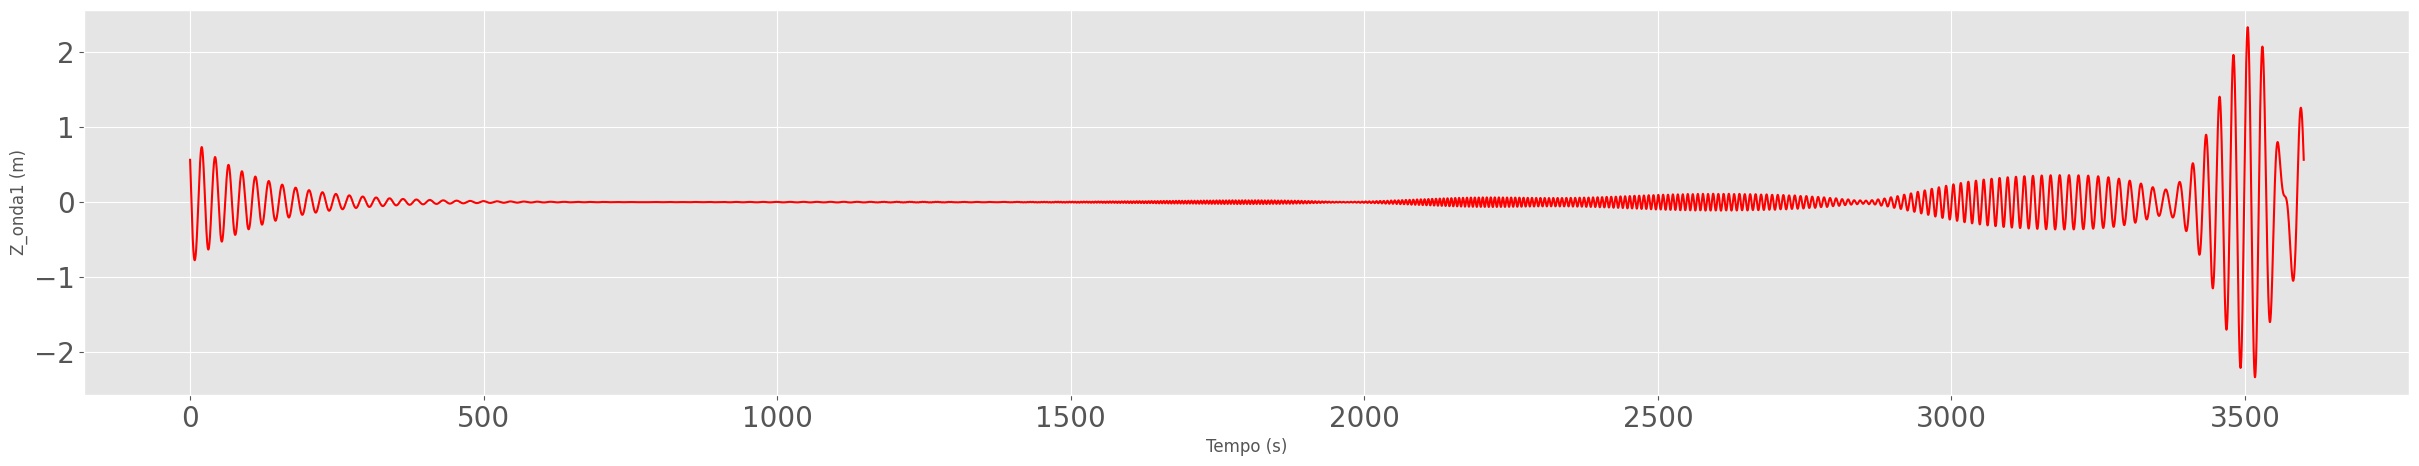

In [7]:
# Plotagem no dominio do tempo
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.figure(figsize=(30,5))
plt.plot(t,data,'r')
plt.xlabel('Tempo (s)')
plt.ylabel('Z_onda1 (m)');

### Cálculo do Espectro de Energia de Onda e Energia de Movimento

In [8]:
# Alterar variavel "data" para mudar onda analisada
data = Z_onda3
data = np.array(data)

In [9]:
# Serie Temporal
yf = fft(data)              # numero complexo (amplitude, fase)

# Vetor de frequencias
Delta_f = 1/(tf-t0)                 # Incremento de frequencias
vetor_f = np.arange(N) * Delta_f    # Vetor de frequencias

In [10]:
# Remoção das frequencias de Aliasing
yf = 2*yf[0:N//2]
w_onda = 2*np.pi*vetor_f[0:N//2]

In [11]:
Delta_w = 2*np.pi*Delta_f       # Frequencia angular
zeta_a = np.abs(yf)/N           # Amplitude da onda
Sw = (zeta_a**2)/(2*Delta_w)    # Espectro de energia

In [12]:
# FFT utilizando o metodo de Welch
f_welch, Sf_welch = welch(data, fs=1/(t[1]-t[0]), nperseg=int(N/10))
w_welch = f_welch*2*np.pi
Sw_welch = Sf_welch/(2*np.pi)

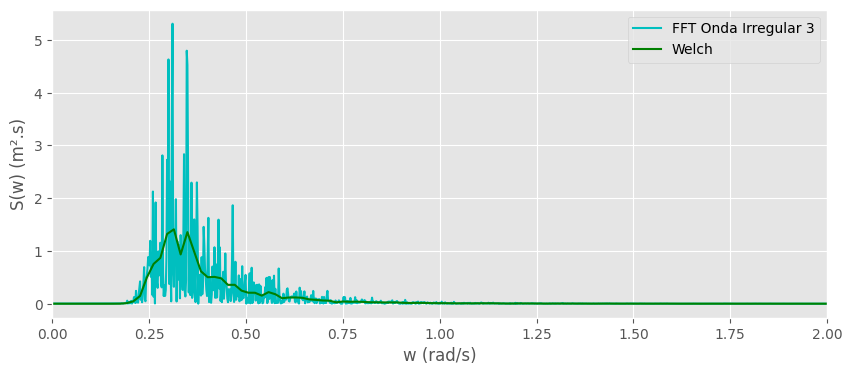

In [13]:
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams.update({'font.size': 10})
plt.figure(figsize=(10,4), dpi= 100)
plt.plot(w_onda, Sw,'c')
plt.plot(w_welch, Sw_welch,'g',linewidth=1.5)
plt.ylabel('S(w) (m².s)')
plt.xlabel('w (rad/s)')
plt.xlim((0,2))
plt.legend(('FFT Onda Irregular 3', 'Welch'));

### Análise estatística no domínio da frequência

In [14]:
m0 = np.trapezoid(Sw, w_onda)
m1 = np.trapezoid((w_onda**1) * Sw, w_onda)
m2 = np.trapezoid((w_onda**2) * Sw, w_onda)
m4 = np.trapezoid((w_onda**4) * Sw, w_onda)
T1 = 2*np.pi * (m0/m1)
T2 = 2*np.pi * np.sqrt(m0/m2)
T4 = 2*np.pi * np.sqrt(m2/m4)
Tp = 1/w_onda[np.argmax(Sw)]
Hs = 4*np.sqrt(m0)

print('Altura significativa:')
print('Hs = ', Hs)
print('Momentos Espectrais:')
print('m0 = ', m0)
print('m1 = ', m1)
print('m2 = ', m2)
print('m4 = ', m4)
print('Períodos Característicos:')
print('T1 = ', T1)
print('T2 = ', T2)
print('T4 = ', T4)
print('Tp = ', Tp)

Altura significativa:
Hs =  1.9795501974589178
Momentos Espectrais:
m0 =  0.24491368651622755
m1 =  0.0969478993673997
m2 =  0.046311169018799954
m4 =  0.6140490664600136
Períodos Característicos:
T1 =  15.872835684807086
T2 =  14.449190741253792
T4 =  1.7255247882445994
Tp =  3.2188640175888947


### Cálculo do RAO experimental

In [15]:
# Alterar variavel "data_RAO" para mudar onda analisada
data_RAO = [Z_onda3, Z_heave3]

In [16]:
for k in range(2):
    yf = fft(data_RAO[k])
    yf = 2*yf[0:N//2]

    Delta_w = 2*np.pi*(1/(tf-t0))
    zeta_a = np.abs(yf)/N
    Sw = (zeta_a**2)/(2*Delta_w)

    if k == 0:
        Sw_wave = Sw
    else:
        Sw_heave = Sw

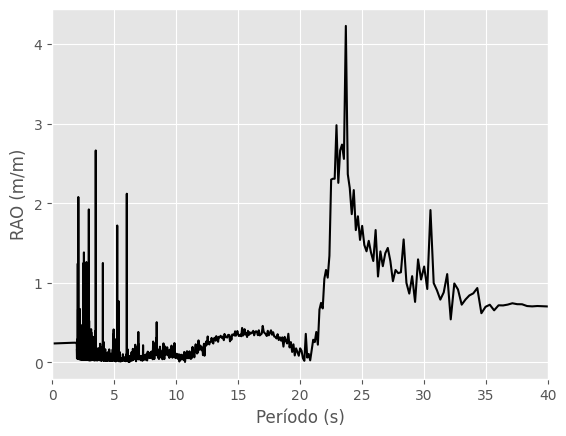

In [17]:
RAO_exp = np.sqrt(Sw_heave/Sw_wave)
plt.plot((2*np.pi)/w_onda[1:], RAO_exp[1:],'k')
plt.ylabel('RAO (m/m)')
plt.xlabel('Período (s)')
plt.xlim((0,40));

### Cálculo do RAO numérico para a plataforma

In [18]:
# Parametros ambientais
g = 9.81    # aceleracao da gravidade
rho = 1025  # densidade da agua
alfa = 90.0001*np.pi/180    # direcao de onda

# Dimensoes da Plataforma
Lp = 50     # meio comprimento do pontoon
H = 32      # calado
Lc = 18     # lado da coluna

## Colunas
Sc = Lc**2      # area seccional de cada coluna
AWF = 6*Sc      # area de linha d'agua
Vc  = AWF*H     # Volume deslocado total das colunas

## Pontoons
Sp = (Lp*2)**2-(Lp*2-Lc*2)**2   # area seccional
Vp = Sp*H                       # Volume deslocado total

# Outros fatores
Rg = 0.5*Lp     # Raio de giro para calculo da inercia propria da plataforma
zetah = 0.02    # amortecimento heave
zetar = 0.05    # amortecimento roll
zetap = 0.05    # amortecimento pitch
CM = 1.2        # coeficiente de massa adicional

## Valores Totais
VT = Vp + Vc
Massa_plat = rho*VT
I_plat = Massa_plat*(Rg**2)

In [19]:
Mah = CM*rho*Vp # massa adicional de heave
wnh = np.sqrt(rho*g*AWF/(Massa_plat+Mah))

print(f'wn_heave = {wnh:.2f} rad/s')
print(f'Tn_heave = {2*np.pi/wnh:.2f} s')

wn_heave = 0.20 rad/s
Tn_heave = 31.45 s


In [20]:
# Definição do intervalo de freqüências de onda e número de onda (águas profundas)
w = np.linspace(2*np.pi/600, 2*np.pi/4, 18000);
k = (w**2)/g # relação de dispersão

A_onda = 1 # amplitude unitária para adimensionalização

# Força nos pontoons / m de onda
Fp = -(1+CM)*rho*Vp*(w**2)*A_onda*np.exp(-k*(H-Lc/2))
Q1 = 0.5*(np.sin(k*Lp*np.cos(alfa))*np.cos(k*Lp*np.sin(alfa)) / (k*Lp*np.cos(alfa)) + np.sin(k*Lp*np.sin(alfa))*np.cos(k*Lp*np.cos(alfa)) / (k*Lp*np.sin(alfa)))

# Força nas colunas
Fc = rho*g*AWF*A_onda*np.exp(-k*H)
G1 = np.cos(k*(Lp+Lc/2)*np.sin(alfa))*np.cos(k*(Lp+Lc/2)*np.cos(alfa))

# Força total
Fres_heave = Fc*G1 + Fp*Q1

# RAO
RAO_heave = np.abs(Fres_heave)/(rho*g*AWF*np.sqrt((1-((w/wnh)**2))**2+((2*zetah*(w/wnh))**2)))

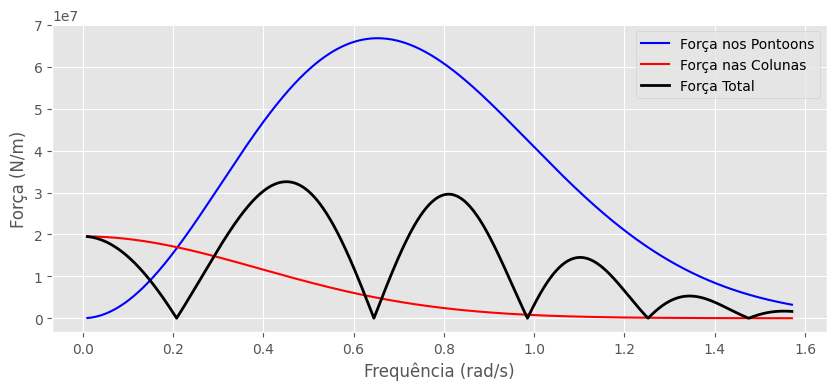

In [21]:
# Grafico de forças nos pontoons e colunas
plt.figure(figsize=(10,4), dpi= 100)
plt.plot(w, np.abs(Fp), 'b', linewidth=1.5)
plt.plot(w, np.abs(Fc), 'r', linewidth=1.5)
plt.plot(w, np.abs(Fres_heave), 'k', linewidth=2)
plt.ylabel('Força (N/m)')
plt.xlabel('Frequência (rad/s)')
plt.legend(('Força nos Pontoons', 'Força nas Colunas', 'Força Total'));

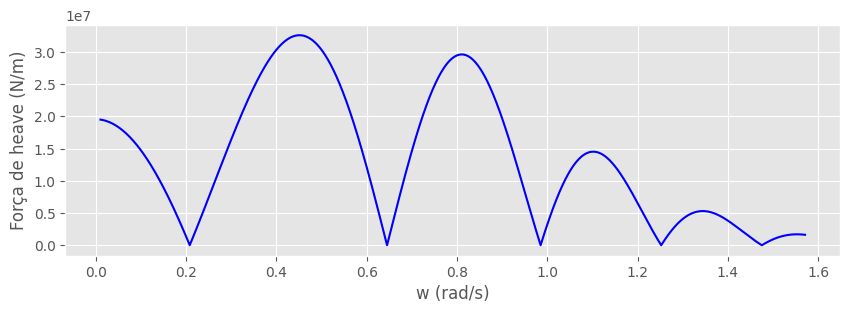

In [22]:
plt.figure(figsize=(10,3), dpi= 100)
plt.plot(w,np.abs(Fres_heave),'b')
plt.xlabel('w (rad/s)')
plt.ylabel('Força de heave (N/m)');

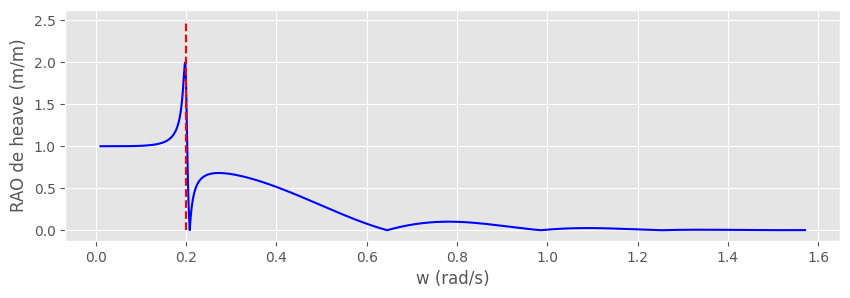

In [23]:
plt.figure(figsize=(10,3), dpi= 100)
plt.plot(w,RAO_heave,'b')
plt.xlabel('w (rad/s)')
plt.ylabel('RAO de heave (m/m)')
plt.plot([wnh, wnh], [0, 2.5], 'r--');

### Cálculo do espectro de JONSWAP

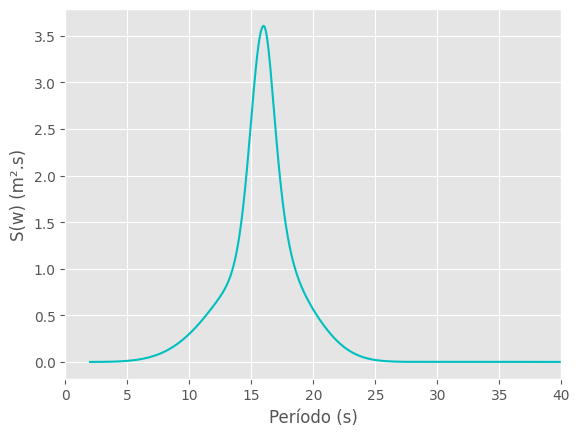

In [24]:
N = 18000
gama = 3.3
w = np.linspace(2*np.pi/100, 2*np.pi/2, N)
tp = 16
hs = 2.7

# JONSWAP
def jonswap(hs,tp):
    Sw = (2*np.pi)**-1*(5/16*hs**2*tp*((2*np.pi/tp)/w)**5*(1-0.287*np.log(gama))*np.exp(-1.25*(w/(2*np.pi/tp))**-4)*gama**np.exp(-((w-(2*np.pi/tp))/2/np.pi)**2/(2*((w<=(2*np.pi/tp))*0.07+(w>(2*np.pi/tp))*0.09)**2*((2*np.pi/tp)/2/np.pi)**2)))
    return Sw

Sw_JS = jonswap(hs, tp)

plt.plot(2*np.pi/w, Sw_JS, 'c')
plt.ylabel('S(w) (m².s)')
plt.xlabel('Período (s)')
plt.xlim((0,40));

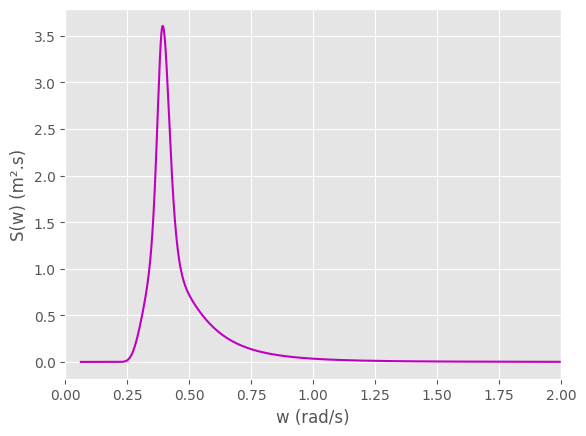

In [25]:
plt.plot(w, Sw_JS, 'm')
plt.ylabel('S(w) (m².s)')
plt.xlabel('w (rad/s)')
plt.xlim((0,2));

### Cruzamento espectral - RAOs e JONSWAP

In [26]:
Sw_resp = Sw_JS * RAO_heave**2

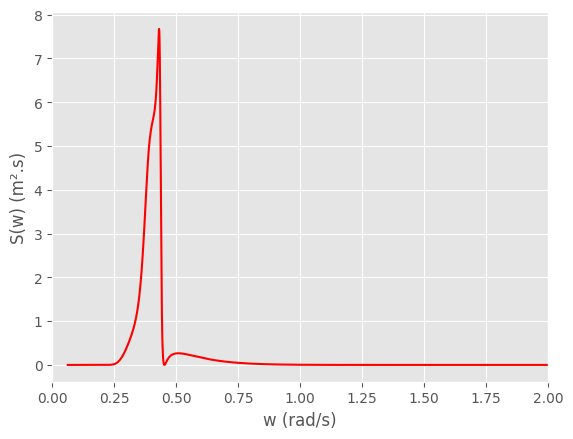

In [27]:
plt.plot(w, Sw_resp, 'r')
plt.ylabel('S(w) (m².s)')
plt.xlabel('w (rad/s)')
plt.xlim((0,2));

In [28]:
m0 = np.trapezoid(Sw_resp, w)
m1 = np.trapezoid((w**1) * Sw_resp, w)
m2 = np.trapezoid((w**2) * Sw_resp, w)
m4 = np.trapezoid((w**4) * Sw_resp, w)
T1 = 2*np.pi * (m0/m1)
T2 = 2*np.pi * np.sqrt(m0/m2)
T4 = 2*np.pi * np.sqrt(m2/m4)
Tp = 1/w[np.argmax(Sw_resp)]
Hs = 4*np.sqrt(m0)

print('Altura significativa:')
print('Hs = ', Hs)
print('Momentos Espectrais:')
print('m0 = ', m0)
print('m1 = ', m1)
print('m2 = ', m2)
print('m4 = ', m4)
print('Períodos Característicos:')
print('T1 = ', T1)
print('T2 = ', T2)
print('T4 = ', T4)
print('Tp = ', Tp)

Altura significativa:
Hs =  2.9010542136354895
Momentos Espectrais:
m0 =  0.5260072219032643
m1 =  0.21834936688004566
m2 =  0.09363335188365447
m4 =  0.020128778638180543
Períodos Característicos:
T1 =  15.136296914241143
T2 =  14.892254057725923
T4 =  13.55147105176826
Tp =  2.3196134455456248
